In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from scipy.interpolate import interp2d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output, N):
    super().__init__()
    # optimisers    

    # constants and stuff
    self.r_rms, self.t_rms = self.sample(N)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_rms.cpu().detach().numpy(), self.t_rms.cpu().detach().numpy())).to(device)
    self.N = N
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16

    self.a = torch.nn.Parameter(torch.tensor(0.).requires_grad_(True).to(device))
    self.b = torch.nn.Parameter(torch.tensor(0.).requires_grad_(True).to(device))
    self.c = torch.nn.Parameter(torch.tensor(0.).requires_grad_(True).to(device))
    self.d = torch.nn.Parameter(torch.tensor(0.).requires_grad_(True).to(device))

    self.params = [self.a, self.b, self.c, self.d]

    # storing D and loss values
    self.Ds = []
    self.loss_list = []

    # activation function
    activation = nn.Tanh

    # c network
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])
    init.xavier_uniform_(self.fci[0].weight)
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])
    for i in range(width-1):
      init.xavier_uniform_(self.fch[i][0].weight)
    self.fco = nn.Linear(depth, output)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x

  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_rms, t_rms):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_rms)):
      r = np.round(10000 * r_rms[i]).astype(int)[0]
      t = np.round(400 * t_rms[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
        # sample points for training
        r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
    
        return r, t
  
  def Diffusion_Coeff(self, c, D_ref):
    # constants
    #D_ref = 2e-16
    c_max = 4.665e4
    C_theory = 277.84
    C_practical = 160

    # equations
    SOC = (c_max - c*c_max)/c_max * C_theory/C_practical
    D = D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def D_PINN(self, c):


    D = self.a.item()*c**3 + self.b.item()*c**2 + self.c.item()*c + self.d.item()

    return D

  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.D_PINN(c*self.c_max)
    #D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss


  def losses(self):
 
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0
  

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.D_PINN(c)
    rs_loss = (D*1e-13*c_r + j*Rs/c_max)**2

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_rms, self.t_rms)
    comp_loss = 1/self.c_max*((torch.sub(c, self.c_numerical.unsqueeze(1))))**2
  
    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)
    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    for epoch in range(epochs_adam):
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      print(f'Epoch: {epoch}  Loss: {loss.item()}, {self.a.item(), self.b.item(),  self.d.item()}', end='\r')

    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      self.loss_list.append(loss.item())
      loss = self.optimizer_lbfgs.step(self.closure)

      print(f'Epoch: {epochs_adam + epoch}  Loss: {self.loss_list[-1]}, {self.a.item(), self.b.item(), self.d.item()}', end='\r')

    self.plot()
    self.plot_D()
    self.plot_loss()
    self.plot_comparison()
    self.error()

    return self.losses

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()


  def plot_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.D_PINN(c).detach().cpu().numpy()
    c = self.c_max*c.cpu().detach().numpy()


    fig = plt.figure()
    plt.plot(c, D, label='D vs c')
    plt.grid(True)
    plt.xlabel('Concentration (mol/m³)')
    plt.ylabel('Diffusion Coefficient (m²/s)')
    plt.title('Diffusion Coefficient vs Concentration with a cubic approximation')
    plt.show()

  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(9999*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(399*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]
    error = np.absolute(numerical - C.cpu().detach().numpy())/numerical*100
    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))



    phys_loss = self.phys_loss(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1)).view(101, 101).cpu().detach().numpy()

    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(12, 12))

    X, T = self.Rs*10000*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy()

      # Numerical plot
    cs0 = axs[0, 0].contourf(X, T, numerical.T, levels = 15)  # Transpose numerical data
    fig.colorbar(cs0, ax=axs[0, 0], label='Concentration (mol/m³)')
    axs[0, 0].set_title('Numerical Solution')
    axs[0, 0].set_xlabel('T (s)')  # Swap x and y labels
    axs[0, 0].set_ylabel('R (m)')  # Swap x and y labels
    #axs[0].legend()

    # C against X and T
    cs1 = axs[0, 1].contourf(X, T, C.cpu().detach().numpy().T, levels = 15)  # Transpose C data
    fig.colorbar(cs1, ax=axs[0, 1], label='Concentration (mol/m³)')
    axs[0, 1].set_title('Neural Network Solution')
    axs[0, 1].set_xlabel('T (s)')  # Swap x and y labels
    axs[0, 1].set_ylabel('R (m)')  # Swap x and y labels
    #axs[1].legend()
    # Error Surface
    cs2 = axs[1, 0].contourf(X, T, error.T, cmap = 'magma')  # Transpose error data
    fig.colorbar(cs2, ax=axs[1, 0], label='Error %')
    axs[1, 0].set_title('Error Surface')
    axs[1, 0].set_xlabel('T (s)')  # Swap x and y labels
    axs[1, 0].set_ylabel('R (m)')  # Swap x and y labels

    # Physical Loss Surface
    cs3 = axs[1, 1].contourf(X, T, phys_loss.T, cmap = 'magma')  # Transpose phys_loss data
    fig.colorbar(cs3, ax=axs[1, 1], label='Physical Loss')
    axs[1, 1].set_title('Physical Loss Surface')
    axs[1, 1].set_xlabel('T (s)')  # Swap x and y labels
    axs[1, 1].set_ylabel('R (m)')  # Swap x and y labels

    plt.tight_layout()
    plt.show()
    
    return abs_error
    


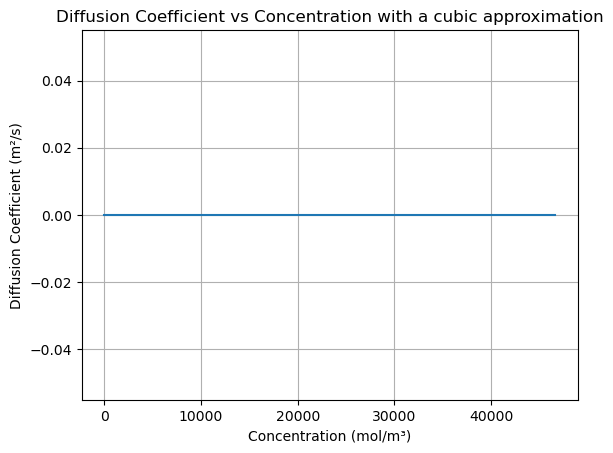

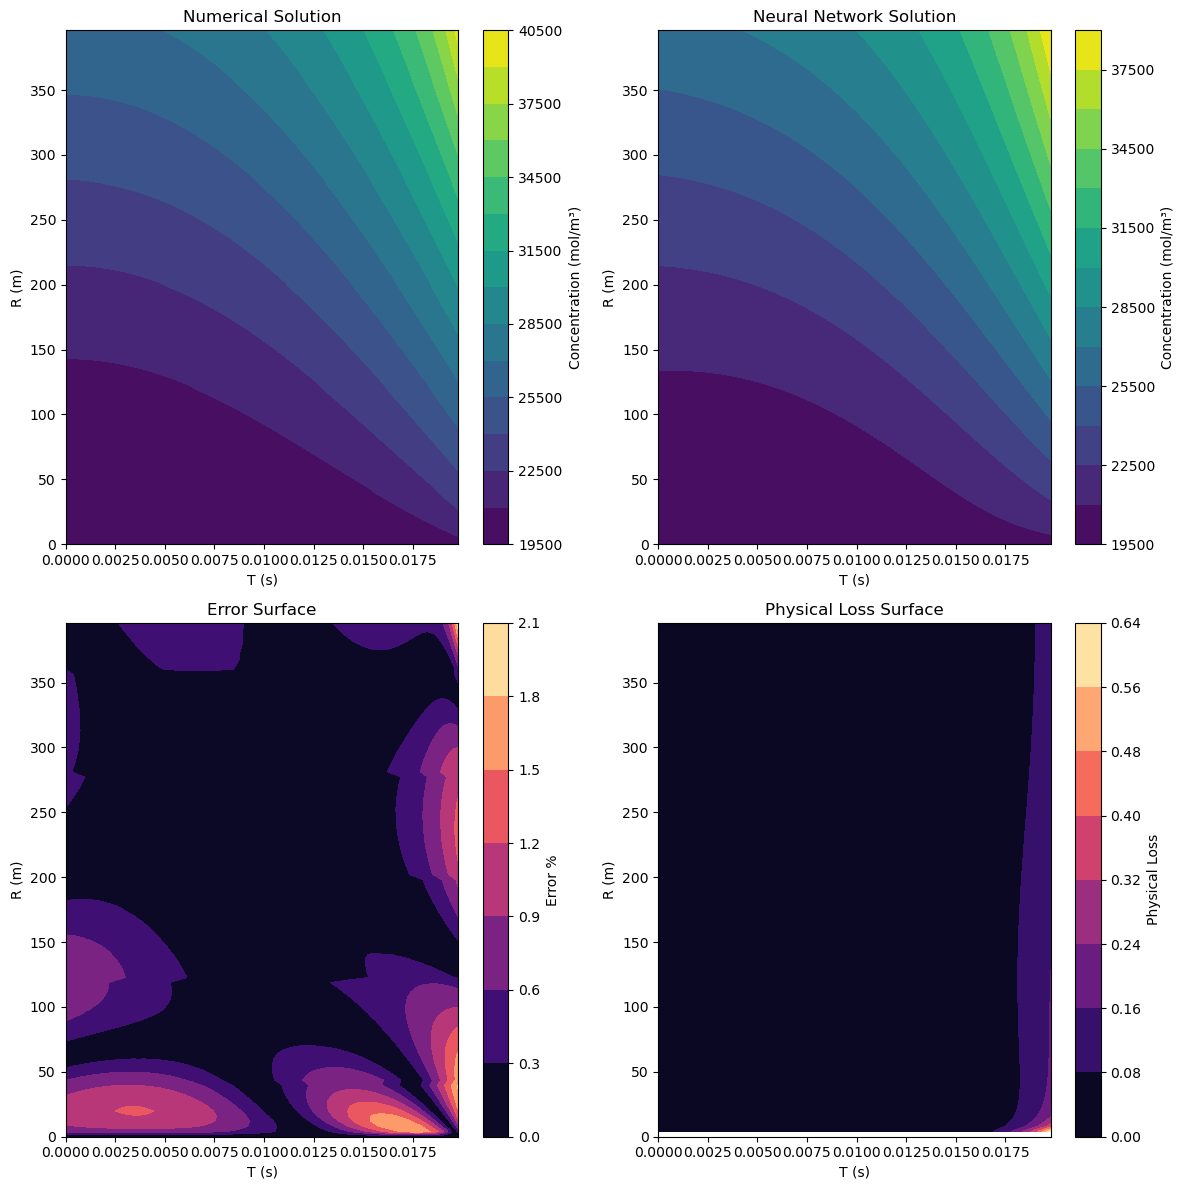

In [18]:
# nn seed
device = 'cuda'
N = 300
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 100


# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1, N).to(device)


losses = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

In [8]:
pinn.a.item(), pinn.b.item(), pinn.c.item(), pinn.d.item()

(0.0, 0.0, 0.0, 0.0)

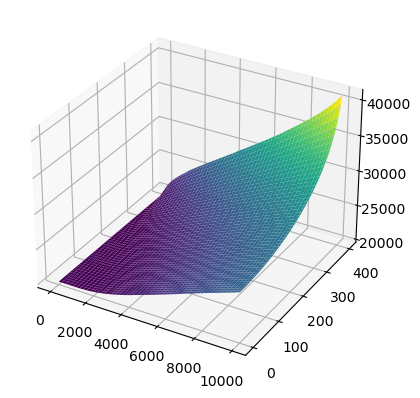

In [132]:
numerical = pd.read_csv("MATLAB Solver\data.csv")

X = np.round(10000 * np.linspace(0, 0.999, 100), 0)
T = np.round(400 * np.linspace(0, 0.999, 100), 0)


    
C = np.zeros((len(X), len(T)))
for i in range(len(X)):
    x = int(X[i])
    for j in range(len(T)):
        t = int(T[j]) 
        C[i, j] = numerical.iloc[x, t]
    
X, T = np.meshgrid(X, T)
fig = plt.figure()
fig.clear()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, C, cmap='viridis')
      
plt.show()




In [7]:
def train_and_time(network_size, epochs, lr, N, device):
    torch.manual_seed(938)

    # Define the NN
    pinn = Network(2, *network_size, 1).to(device)

    # Training
    start_time = time.time()
    Ds, losses = pinn.train(epochs, lr, N)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return elapsed_time

# Set up parameters
epochs = 3000
lr = 1e-3
N = 100

# Define network sizes to test
network_sizes = [
    (3, 32),
    (5, 32),
    (3, 128),
    (5, 128), 
    (5, 256), 
    (10, 256),
        
]

# Set random seed for reproducibility
torch.manual_seed(938)

elapsed_time_cpu = []
elapsed_time_gpu = []
# Train and time for each network size
for i in range(len(network_sizes)):
    size = network_sizes[i]
    elapsed_time_cpu.append = train_and_time(size, epochs, lr, N, 'cpu')
    elapsed_time_gpu.append = train_and_time(size, epochs, lr, N, 'cuda')

# Plot the results
plt.figure()
plt.plot(network_sizes, elapsed_time_cpu, label='CPU')
plt.plot(network_sizes, elapsed_time_gpu, label='GPU')
plt.xlabel('Network size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)